# Unlearning with Neggrad

In [7]:
import torch
from torch.utils.data import DataLoader
from torch.nn.functional import relu, avg_pool2d
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset, Subset
from itertools import cycle

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import time
import random

from cifar import load_cifar10_data, split_into_classes, get_class_indexes 

# import quadprog

import os
import sys
sys.path.append(os.path.abspath("."))  # Adds the current directory

In [8]:
# Path to the dataset
DATASET_PATH = 'cifar-10-batches-py' 
CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_data, train_labels, test_data, test_labels = load_cifar10_data(DATASET_PATH)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# split the data into 10 classes by doing sort by key where in the keys are the labels and the values are the data
train_split = {cls: [] for cls in CLASSES}
for img, label in zip(train_data, train_labels):
    train_split[CLASSES[label]].append(img)
    
# this makes more sense to me, effectively indexes 0-5000 are all airplanes, 5000-10000 are all automobiles etc
test_split = {cls: [] for cls in CLASSES}
for img, label in zip(test_data, test_labels):
    test_split[CLASSES[label]].append(img)

In [9]:
initialisation = time.time()

class ResNet18CIFAR(torch.nn.Module):
    def __init__(self):
        super(ResNet18CIFAR, self).__init__()
        self.resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
        # change the first layer to accept 32x32 images with 3 channels rather than 224x224 images
        # check the size of the input layer
        self.resnet.conv1 = torch.nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.resnet.bn1 = torch.nn.BatchNorm2d(128)
        # change number of blocks per layer
        self.resnet.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            torch.nn.BatchNorm2d(128)
        )
        self.resnet.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            torch.nn.BatchNorm2d(256)
        )
        self.resnet.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            torch.nn.BatchNorm2d(512)
        )
        self.resnet.layer4 = torch.nn.Sequential(
            torch.nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1, bias=False),
            torch.nn.BatchNorm2d(1024),
            torch.nn.ReLU(),
            torch.nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1, bias=False),
            torch.nn.BatchNorm2d(1024)
        )
        # change input layer to accept 32x32 images by utilising smaller convolutional kernel
        self.resnet.fc = torch.nn.Linear(1024, 10)
        # start with 5 classes and add more as needed
        self.resnet.maxpool = torch.nn.Identity()
        # maxpool worsens performance and is unnecessary for small image sizes
        

    def forward(self, x):
        return self.resnet(x)
    
model = ResNet18CIFAR()
model = torch.load("""models\\resnet18_cifar77ACC.pth""")


Using cache found in C:\Users\Tom/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\Tom\AppData\Local\Temp\ipykernel_11220\904961702.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental

In [10]:
# turn the data into a tensor
test_data_tensor = torch.tensor(test_data).float()
test_labels_tensor = torch.tensor(test_labels)

train_data_tensor = torch.tensor(train_data, dtype=torch.float32).cuda()
train_labels_tensor = torch.tensor(train_labels).cuda()

# Define the number of classes in your dataset
num_classes = 10

# Move tensors to GPU if available
if torch.cuda.is_available():
    test_data_tensor = test_data_tensor.cuda()
    test_labels_tensor = test_labels_tensor.cuda()

In [52]:
def evaluate_model(model):
    print("||===================START CLASS-BY-CLASS ACCURACY=================||")
    all_accuracies = []
    # Initialize counters for each class
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    # Test the model
    with torch.no_grad():
        for i in range(0, len(test_data), 1000):
            # Get the input and output
            img = test_data_tensor[i:i + 1000]
            label = test_labels_tensor[i:i + 1000]
            
            model = model.cuda()

            # Get the prediction
            outputs = model(img)
            _, predicted = torch.max(outputs, 1)

            # Update per-class counters
            for lbl, pred in zip(label, predicted):
                class_total[lbl.item()] += 1
                if lbl.item() == pred.item():
                    class_correct[lbl.item()] += 1

            del img

    # Print overall accuracy
    overall_accuracy = sum(class_correct) / sum(class_total) * 100
    print(f"|| Overall Test Accuracy: {overall_accuracy:.2f}% ||")

    # Print accuracy for each class
    for cls in range(num_classes):
        if class_total[cls] > 0:
            class_accuracy = class_correct[cls] / class_total[cls] * 100
            all_accuracies.append(class_accuracy)
            print(f"|| Accuracy for Class {cls}: {class_accuracy:.2f}% ||")
        else:
            print(f"|| No samples for Class {cls} ||")
    
    return all_accuracies

In [12]:
classes_to_unlearn = [0,1,2,3,4]
forget_mask = torch.isin(train_labels_tensor, torch.tensor(classes_to_unlearn).cuda())
retain_mask = ~forget_mask

test_forget_mask = torch.isin(test_labels_tensor, torch.tensor(classes_to_unlearn).cuda())
test_retain_mask = ~test_forget_mask

# Get the indices of the forget and retain subsets
forget_indices = forget_mask.nonzero(as_tuple=True)[0]
retain_indices = retain_mask.nonzero(as_tuple=True)[0]
test_forget_indices = test_forget_mask.nonzero(as_tuple=True)[0]
test_retain_indices = test_retain_mask.nonzero(as_tuple=True)[0]

forget_dataset = TensorDataset(train_data_tensor[forget_indices], train_labels_tensor[forget_indices])
retain_dataset = TensorDataset(train_data_tensor[retain_indices], train_labels_tensor[retain_indices])
test_forget_dataset = TensorDataset(test_data_tensor[test_forget_indices], test_labels_tensor[test_forget_indices])
test_retain_dataset = TensorDataset(test_data_tensor[test_retain_indices], test_labels_tensor[test_retain_indices])

forget = DataLoader(forget_dataset, batch_size=64, shuffle=True)
retain = DataLoader(retain_dataset, batch_size=64, shuffle=True)
test_forget = DataLoader(test_forget_dataset, batch_size=64, shuffle=False)
test_retain = DataLoader(test_retain_dataset, batch_size=64, shuffle=False)

In [19]:
def Neggrad_one_epoch(model, criterion, optimiser, retain_loader : DataLoader, forget_loader : DataLoader, alpha):
    model.train()
    r_losses = []
    del_losses = []
    for idx, ((input, target), (del_input, del_target)) in enumerate(zip(retain_loader, cycle(forget_loader))):
        # if(idx % 1 == 0): print(idx)
        input = input.cuda()
        target = target.cuda()
        del_input = del_input.cuda()
        del_target = del_target.cuda()

        # Forward
        output_clean = model(input)
        del_output_clean = model(del_input)
        r_loss = criterion(output_clean, target)
        del_loss = criterion(del_output_clean, del_target)
        # print(f"r_loss: {r_loss}")
        # print(f"del_loss: {del_loss}")
        loss = alpha*r_loss - (1-alpha)*del_loss

        # Backward
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        loss = loss.float()

        r_losses.append(r_loss.cpu().item())
        del_losses.append(del_loss.cpu().item())
    return r_losses, del_losses

In [14]:
# def evaluate_model(model, criterion, test_retain_loader : DataLoader, test_forget_loader : DataLoader):
#     model.eval()
#     sum_loss = 0
#     total = 0
#     with torch.no_grad():
#         for test_input, test_target in test_retain_loader:
#             test_input = test_input.cuda()
#             test_target = test_target.cuda()

#             outputs = model(test_input)
#             loss = criterion(outputs, test_target)
#             sum_loss += loss.item() * test_input.size(0)
#             total += test_input.size(0)
#         retain_accuracy = sum_loss / total
#         sum_loss = 0
#         total = 0
#         for test_input, test_target in test_forget_loader:
#             test_input = test_input.cuda()
#             test_target = test_target.cuda()

#             outputs = model(test_input)
#             loss = criterion(outputs, test_target)
#             sum_loss += loss.item() * test_input.size(0)
#             total += test_input.size(0)
#         forget_accuracy = sum_loss / total

#     return retain_accuracy, forget_accuracy




In [15]:
EPOCHS = 1
ALPHA = 0.99

In [ ]:
model = torch.load("""models\\resnet18_cifar77ACC.pth""")
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
model = model.cuda()

evaluate_model(model)

for i in range(EPOCHS):
    print(f"Epoch {i + 1}/{EPOCHS}:",end=None)
    start = time.time()
    Neggrad_one_epoch(model,criterion,optimiser, retain, forget, ALPHA)
    print(f"({time.time() - start})")
    evaluate_model(model)
    
    
    

In [40]:
resultsdict = {}
for alpha in [0.9,0.95,0.99,0.995, 0.999]:
    model = torch.load("""models\\resnet18_cifar77ACC.pth""")
    criterion = nn.CrossEntropyLoss()
    optimiser = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    model = model.cuda()

    # evaluate_model(model)

    print(alpha)
    for i in range(EPOCHS):
        print(f"Epoch {i + 1}/{EPOCHS}:",end=None)
        start = time.time()
        r_losses, del_losses = Neggrad_one_epoch(model,criterion,optimiser, retain, forget, alpha)
        print(f"({time.time() - start})")
        evaluate_model(model)
        resultsdict.update({alpha: (r_losses, del_losses)})

C:\Users\Tom\AppData\Local\Temp\ipykernel_11220\54201613.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("""models\\resnet18_cifar77ACC.pth""")


0.9
Epoch 1/1:
(44.31371545791626)
||===================START CLASS-BY-CLASS ACCURACY=================||
|| Overall Test Accuracy: 15.37% ||
|| Accuracy for Class 0: 0.00% ||
|| Accuracy for Class 1: 0.00% ||
|| Accuracy for Class 2: 0.00% ||
|| Accuracy for Class 3: 0.00% ||
|| Accuracy for Class 4: 0.00% ||
|| Accuracy for Class 5: 0.00% ||
|| Accuracy for Class 6: 0.00% ||
|| Accuracy for Class 7: 73.70% ||
|| Accuracy for Class 8: 80.00% ||
|| Accuracy for Class 9: 0.00% ||
0.95
Epoch 1/1:
(53.57719564437866)
||===================START CLASS-BY-CLASS ACCURACY=================||
|| Overall Test Accuracy: 14.33% ||
|| Accuracy for Class 0: 0.00% ||
|| Accuracy for Class 1: 0.00% ||
|| Accuracy for Class 2: 0.00% ||
|| Accuracy for Class 3: 0.00% ||
|| Accuracy for Class 4: 0.00% ||
|| Accuracy for Class 5: 45.30% ||
|| Accuracy for Class 6: 0.00% ||
|| Accuracy for Class 7: 1.90% ||
|| Accuracy for Class 8: 96.10% ||
|| Accuracy for Class 9: 0.00% ||
0.99
Epoch 1/1:
(55.4243752956390

Alpha 0.9
3.016300556399411e+17
2.1195560526544896e+18

Alpha 0.95
11611301.0
868634496.0

Alpha 0.99
1.9021955728530884
590.8641967773438

Alpha 0.999
1.0634000301361084
17.566068649291992

Alpha 0.995
0.7410945296287537
99.39539337158203



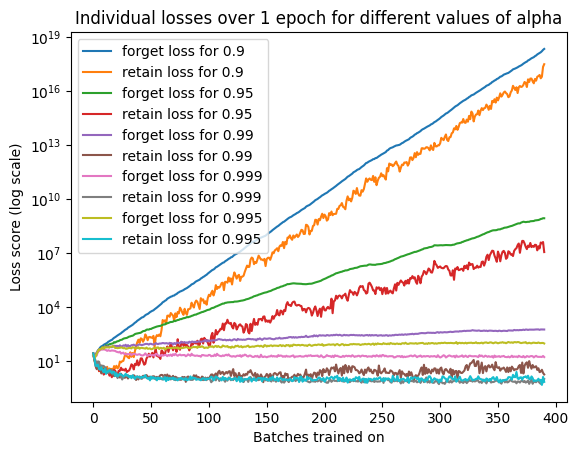

In [39]:
for a in resultsdict.keys():
    plt.plot(range(len(resultsdict[a][1])),resultsdict[a][1],label = f"forget loss for {a}")
    plt.plot(range(len(resultsdict[a][0])),resultsdict[a][0], label = f"retain loss for {a}")
    print(f"Alpha {a}")
    print(resultsdict[a][0][-1])
    print(resultsdict[a][1][-1])
    print()

plt.title("Individual losses over 1 epoch for different values of alpha")
plt.xlabel("Batches trained on")
plt.ylabel(f"Loss score (log scale)")
plt.yscale("log")
plt.legend()
plt.show()


In [44]:
def get_random_subset(dataloader : DataLoader, subset_fraction : float) -> DataLoader :
    subset_size = int(len(dataloader.dataset) * subset_fraction)

    subset_indices = torch.randperm(len(dataloader.dataset))[:subset_size]
    subset_forget_dataset = Subset(dataloader.dataset, subset_indices.tolist())
    return DataLoader(subset_forget_dataset, batch_size=64, shuffle=True)

In [ ]:
ALPHA = 0.995
subsets_checked =  [0.01,0.1,0.2,0.5,0.7]
subset_results = {}
# evaluate_model(model)
for retain_size in subsets_checked:
    print(f"||===================Retain: {retain_size}=================||")
    training_retain_subset = get_random_subset(retain,retain_size)
    for forget_size in subsets_checked:
        model = torch.load("""models\\resnet18_cifar77ACC.pth""")
        optimiser = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
        criterion = nn.CrossEntropyLoss()
        training_forget_subset = get_random_subset(forget,forget_size)
        print(f"||===================Forget: {forget_size}=================||")
        for i in range(EPOCHS):
            print(f"Epoch {i + 1}/{EPOCHS}:",end=None)
            start = time.time()
            Neggrad_one_epoch(model,criterion,optimiser, training_retain_subset, training_forget_subset, ALPHA)
            print(f"({time.time() - start})")
            r = evaluate_model(model)
            subset_results.update({(retain_size,forget_size) : r})
    print()
    print()

||===================Retain: 0.01=================||
||===================Forget: 0.01=================||
Epoch 1/1:


C:\Users\Tom\AppData\Local\Temp\ipykernel_11220\2216966720.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("""models\\resnet18_cifar77ACC.pth""")


(0.6643187999725342)
||===================START CLASS-BY-CLASS ACCURACY=================||
|| Overall Test Accuracy: 15.20% ||
|| Accuracy for Class 0: 0.00% ||
|| Accuracy for Class 1: 0.00% ||
|| Accuracy for Class 2: 0.00% ||
|| Accuracy for Class 3: 0.00% ||
|| Accuracy for Class 4: 0.00% ||
|| Accuracy for Class 5: 0.00% ||
|| Accuracy for Class 6: 0.00% ||
|| Accuracy for Class 7: 79.10% ||
|| Accuracy for Class 8: 43.10% ||
|| Accuracy for Class 9: 29.80% ||
||===================Forget: 0.1=================||
Epoch 1/1:
(0.4498739242553711)
||===================START CLASS-BY-CLASS ACCURACY=================||
|| Overall Test Accuracy: 12.58% ||
|| Accuracy for Class 0: 0.00% ||
|| Accuracy for Class 1: 0.00% ||
|| Accuracy for Class 2: 0.00% ||
|| Accuracy for Class 3: 0.00% ||
|| Accuracy for Class 4: 0.00% ||
|| Accuracy for Class 5: 0.00% ||
|| Accuracy for Class 6: 0.00% ||
|| Accuracy for Class 7: 95.00% ||
|| Accuracy for Class 8: 24.10% ||
|| Accuracy for Class 9: 6.70% |

In [77]:
print("Class score for the retain sets")
print("(Retain size, Forget size), scores, mean, std")
for key in subset_results:
    forget_results = subset_results[key][0:5]
    retain_results = subset_results[key][5:10]
    print(key, [round(x,3) for x in retain_results], round(np.mean(retain_results),3), round(np.std(retain_results),3))


    

Class score for the retain sets
(Retain size, Forget size), scores, mean, std
(0.01, 0.01) [0.0, 0.0, 79.1, 43.1, 29.8] 30.4 29.603
(0.01, 0.1) [0.0, 0.0, 95.0, 24.1, 6.7] 25.16 36.015
(0.01, 0.2) [0.0, 0.5, 25.0, 48.5, 60.2] 26.84 24.493
(0.01, 0.5) [0.0, 0.0, 79.4, 13.6, 49.9] 28.58 31.29
(0.01, 0.7) [0.0, 0.0, 0.0, 65.6, 61.2] 25.36 31.091
(0.1, 0.01) [19.4, 71.0, 55.7, 70.4, 38.7] 51.04 19.74
(0.1, 0.1) [51.4, 10.8, 17.4, 48.1, 90.7] 43.68 28.502
(0.1, 0.2) [51.9, 56.0, 10.9, 87.1, 56.1] 52.4 24.303
(0.1, 0.5) [35.3, 8.5, 15.9, 14.1, 96.8] 34.12 32.617
(0.1, 0.7) [38.4, 46.7, 68.3, 69.3, 37.4] 52.02 14.08
(0.2, 0.01) [43.5, 90.7, 34.4, 78.0, 44.2] 58.16 22.031
(0.2, 0.1) [0.6, 79.6, 70.3, 80.8, 40.7] 54.4 30.551
(0.2, 0.2) [11.7, 46.8, 81.1, 88.9, 37.5] 53.2 28.505
(0.2, 0.5) [52.8, 70.5, 40.2, 85.9, 43.3] 58.54 17.281
(0.2, 0.7) [17.0, 79.3, 73.8, 71.2, 43.6] 56.98 23.498
(0.5, 0.01) [33.9, 69.7, 71.9, 93.5, 41.1] 62.02 21.799
(0.5, 0.1) [42.3, 77.6, 69.7, 60.6, 81.3] 66.3 13.948


In [79]:
print("Average score of the retained classes")
print("Retain subset size -->")
print("Forget subset size V")
print("   ",subsets_checked)
for y in subsets_checked:
    print(y,end="|")
    for x in subsets_checked:
        print(f"{round(np.mean(subset_results[(x,y)][5:10]),3)} ", end="")
    print()

print()
print()
print("std of the score of the retained classes")
print("Retain subset size -->")
print("Forget subset size V")
print("   ",subsets_checked)
for y in subsets_checked:
    print(y,end="|")
    for x in subsets_checked:
        print(f"{round(np.std(subset_results[(x,y)][5:10]),3)} ", end="")
    print()

Average score of the retained classes
Retain subset size -->
Forget subset size V
    [0.01, 0.1, 0.2, 0.5, 0.7]
0.01|30.4 51.04 58.16 62.02 62.92 
0.1|25.16 43.68 54.4 66.3 62.64 
0.2|26.84 52.4 53.2 61.7 68.2 
0.5|28.58 34.12 58.54 67.24 67.6 
0.7|25.36 52.02 56.98 59.0 64.66 


std of the score of the retained classes
Retain subset size -->
Forget subset size V
    [0.01, 0.1, 0.2, 0.5, 0.7]
0.01|29.603 19.74 22.031 21.799 15.148 
0.1|36.015 28.502 30.551 13.948 27.06 
0.2|24.493 24.303 28.505 21.692 10.972 
0.5|31.29 32.617 17.281 11.0 11.844 
0.7|31.091 14.08 23.498 28.027 10.997 
